In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential

# For GPU users

In [25]:
physical_devices = tf.config.list_physical_devices('GPU')
print(f'GPU: {physical_devices}')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

GPU: []


# Dataset from google drive

In [26]:
# from google.colab import drive

# drive.mount('/content/drive/')
# data_folder_path = '/content/drive/MyDrive/'

# Dataset create

In [27]:
import os
import cv2 
import numpy as np

cutter_dir = './data/cutter/'
rubber_dir = './data/rubber/'

def load_images(directory):
    images = []
    labels = []
    idx = 1
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            print(f"\rimage no: {idx}", end='')
            idx = idx + 1
            img = cv2.imread(os.path.join(directory, filename))
            img = cv2.resize(img, (32, 32))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img)
            if directory == cutter_dir:
                labels.append(0)
            elif directory == rubber_dir:
                labels.append(1)
    return images, labels

cat_images, cat_labels = load_images(cutter_dir)
print()
dog_images, dog_labels = load_images(rubber_dir)
print()

images = np.array(cat_images + dog_images)
labels = np.array(cat_labels + dog_labels)
images = images / 255.0

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


image no: 1

image no: 44

Invalid SOS parameters for sequential JPEG


image no: 97

Invalid SOS parameters for sequential JPEG


image no: 465
image no: 348

Invalid SOS parameters for sequential JPEG


image no: 403

Invalid SOS parameters for sequential JPEG


image no: 421
Images shape: (886, 32, 32)
Labels shape: (886,)


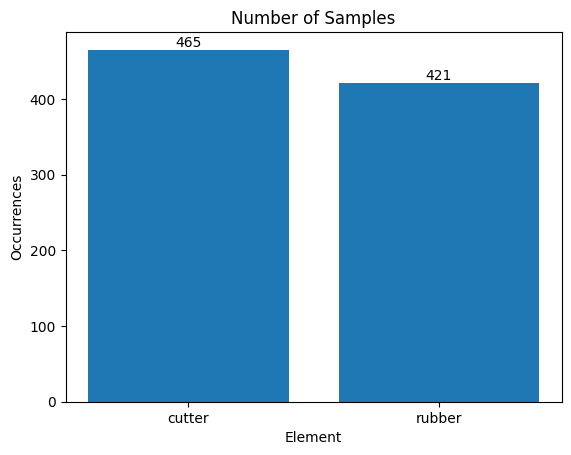

In [28]:

values, counts = np.unique(labels, return_counts=True)

plt.bar(values, counts)
plt.xlabel('Element')
plt.ylabel('Occurrences')
plt.title('Number of Samples')

for i, count in enumerate(counts):
    plt.text(values[i], count, str(count), ha='center', va='bottom')

plt.xticks(values, ['cutter', 'rubber'])
plt.show()


In [44]:
# Shuffle the data
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

Label: rubber


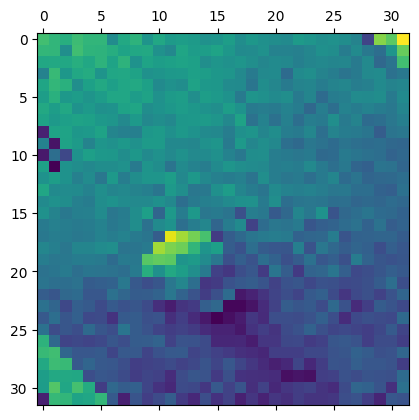

In [45]:
idx = 20
print("Label:", 'cutter' if labels[idx]==0 else 'rubber')
plt.matshow(images[idx])

# Spliting the dataset

In [46]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

Training images shape: (637, 32, 32)
Training labels shape: (637,)
Validation images shape: (71, 32, 32)
Validation labels shape: (71,)
Testing images shape: (178, 32, 32)
Testing labels shape: (178,)


# CNN Model

In [58]:
model = Sequential([
    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu', padding='same'),
    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu', padding='same'),
    MaxPooling2D(),
    Conv2D(filters=128, kernel_size = (3,3), activation = 'relu', padding='same'),
    Conv2D(filters=128, kernel_size = (3,3), activation = 'relu', padding='same'),
    Conv2D(filters=128, kernel_size = (3,3), activation = 'relu', padding='same'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

model.build(input_shape=(None, 32, 32, 1))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_50 (Conv2D)          (None, 16, 16, 128)       147584    
                                                      

In [48]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20)


Epoch 1/20
20/20 [==============================] - 14s 585ms/step - loss: 0.7267 - accuracy: 0.5165 - val_loss: 0.6929 - val_accuracy: 0.4648
Epoch 2/20
20/20 [==============================] - 12s 588ms/step - loss: 0.6898 - accuracy: 0.5196 - val_loss: 0.6915 - val_accuracy: 0.5352
Epoch 3/20
20/20 [==============================] - 12s 596ms/step - loss: 0.6652 - accuracy: 0.5981 - val_loss: 0.6072 - val_accuracy: 0.6338
Epoch 4/20
20/20 [==============================] - 16s 811ms/step - loss: 0.5884 - accuracy: 0.6907 - val_loss: 0.5649 - val_accuracy: 0.7606
Epoch 5/20
20/20 [==============================] - 15s 762ms/step - loss: 0.5047 - accuracy: 0.7645 - val_loss: 0.4435 - val_accuracy: 0.8169
Epoch 6/20
20/20 [==============================] - 13s 673ms/step - loss: 0.4021 - accuracy: 0.8132 - val_loss: 0.3308 - val_accuracy: 0.8592
Epoch 7/20
20/20 [==============================] - 14s 694ms/step - loss: 0.3400 - accuracy: 0.8367 - val_loss: 0.3033 - val_accuracy: 0.8451

# Model history view

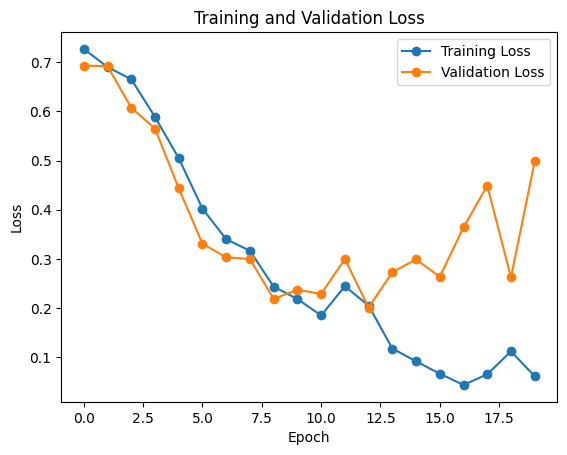

In [52]:
plt.plot(history.history['loss'],  '-o',  label='Training Loss')
plt.plot(history.history['val_loss'], '-o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

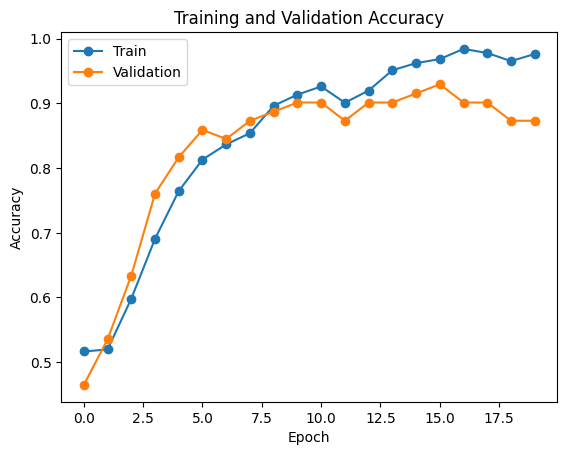

In [53]:
plt.plot(history.history['accuracy'], '-o')
plt.plot(history.history['val_accuracy'], '-o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing

In [54]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss :.7f}")
print(f"Test Accuracy: {test_accuracy*100 :.3f}%")

6/6 [==============================] - 1s 140ms/step - loss: 0.4157 - accuracy: 0.8708
Test Loss: 0.4156584
Test Accuracy: 87.079%


In [55]:
y_pred = model.predict(test_images)
y_pred_labels = [np.argmax(i) for i in y_pred]
y_pred[0]

6/6 [==============================] - 1s 100ms/step


array([9.9983788e-01, 1.6214442e-04], dtype=float32)

Actual: rubber


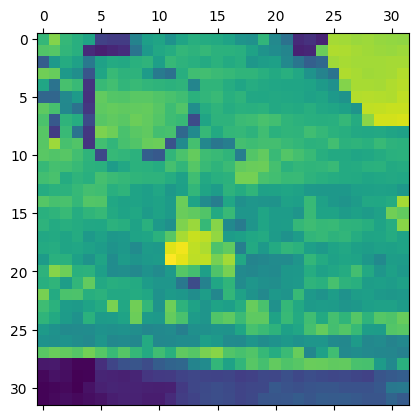

In [56]:
idx = 25
print(f'Actual: {"cutter" if np.argmax(y_pred[idx]) == 0 else "rubber"}')
plt.matshow(test_images[idx])

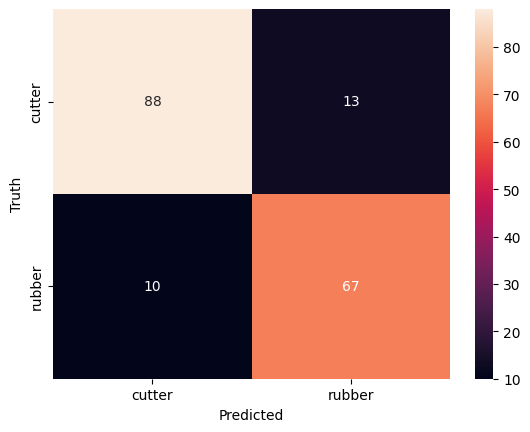

In [57]:
import seaborn as sn

cm = tf.math.confusion_matrix(labels=test_labels, predictions=y_pred_labels)

heatmap = sn.heatmap(cm, annot=True, fmt='d')

heatmap.set_xlabel('Predicted')
heatmap.set_ylabel('Truth')
heatmap.set_xticklabels(['cutter', 'rubber'], ha='center')
heatmap.set_yticklabels(['cutter', 'rubber'], va='center')

plt.show()